In [1]:
import _thread
import time
import cv2
import numpy as np 
import os
import datetime as dt
from autoencoder_model import Segmenter
import requests 

video_rec = []
def video_thread(video_src = 0):
    global video_rec
    cap = cv2.VideoCapture(video_src)
    if type(video_src)== int:
        cap.set(3, 1920)
        cap.set(4, 1080)
    while True:
        if type(video_src)==str: time.sleep(1/30)
        if len(video_rec) > 2 : video_rec.pop(0)
        T = round(time.time(),3)
        _, im_np = cap.read()
        if not _:
            print("Video source doesn't respond")
            video_rec.append([])
            break
        video_rec.append([T, im_np])
    cap.release()
    cv2.destroyAllWindows()
#############VIDEO CAMERA THREAD################
def run_video_thread(video_src=0):
    try:
        _thread.start_new_thread(video_thread,(video_src,))
        time.sleep(5)
        print ("vid thread running")
    except:
       print ("Error: unable to start thread")
################################################
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255
        
#Post procesamiento de la mascara obtenida        
def post_mask(img,orig_size=(255,255),flag_multi_class = False,num_class = 2, threshold = 0.5 ):
    img = labelVisualize(num_class,COLOR_DICT,img) if flag_multi_class else img[:,:,0]
    img[img<threshold] = 0
    img[img>=threshold] = 255
    img, area = post_mask_util(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img,orig_size[::-1], interpolation = cv2.INTER_AREA) #resize en opencv esta invertido
    img = img.astype('uint8') 
    return img,area

def post_mask_util(img_bin, kernel_=(3,3)):
    # Clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_)
    # Fill small gaps
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)
    # Remove specks
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    # Contando la cantidad de puntos detectados en la mascara de 256x256
    area = np.sum(img_bin == 255)
    
    return img_bin , area
# Preprocesamiento para la inferencia de la foto
def pre_mask(img_orig, crop = (.3 , .87, .38,.56),size=(256,256)):
    (alto, ancho, chs) = img_orig.shape
    y_ini = int(alto*crop[0])
    y_fin = int(alto*crop[1])
    x_ini = int(ancho*crop[2])
    x_fin = int(ancho*crop[3])
    img_crop = img_orig[y_ini:y_fin,x_ini:x_fin]
    img = img_crop.copy()
    img = img / 255
    img = cv2.resize(img,size, interpolation = cv2.INTER_AREA)
    #img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
    img = np.reshape(img,(1,)+img.shape)
    return img , img_crop # imagen a introducir en la red , dimensiones originales de la imagen de entrada

integer = 0
last_time = 0
worst_leak = 0
#Función para la integración de areas en el tiempo
def lost_condition(area, time,pipe_name):
    # se toma como medida de referencia una taza de 30FPS
    global last_time
    global integer
    global worst_leak
    if area > 30:
        integer += area*(time-last_time)
    else: 
        if worst_leak < integer: 
            worst_leak = integer
            today_time_hr = dt.datetime.now().strftime("%Y-%m-%dT%H:%M:00Z")
            _thread.start_new_thread(post_data2powerBI,(worst_leak,pipe_name, today_time_hr,))
            #post_data2powerBI(worst_leak,pipe_name, today_time_hr)
            print("try send")
        integer = 0
            
def post_data2powerBI(measure,pipe_name, time):
    curl_comand = "curl --include --request POST --header \"Content-Type: application/json\" --data-binary \
    \"[{\\\"Dato_D\\\" :"+str(measure)+",\
    \\\"Tuberia_D\\\" :\\\""+pipe_name+"\\\",\
    \\\"Fecha_D\\\" :\\\""+time+"\\\"}]\" \
    \"https://api.powerbi.com/beta/a40c0d68-338e-44ef-ab17-812ee42d12c7/datasets/bda68983-2b14-49a5-bfe7-69f44d8ea468/rows?key=2N%2BaucfmuwwDj7ywtD2EolHR1XF4RlxeppXiEUSSZw%2BUQxI02yhbru3wzUNX%2F7cROwUKwPssQEaLyzSnvkByIQ%3D%3D\""
    #print(curl_comand)
    os.system(curl_comand)
    #print(reto)
    #url = http://
    #payload= json format
    #formatted_address = data['results'][0]['formatted_address'] 
    #print("Formatted Address:%s"%(formatted_address)) 

## Run Inference

In [2]:
set_ = 0
model = Segmenter(pretrained_weights ="segmenter_unet.hdf5",input_size = (256,256,3))
#pos_cam = [(.3 , .78, .38,.56), (.25,.5,.6,.7)]
pos_cam = [(.3 , .5, .43,.52),(.3 , .78, .38,.56)]
videos = ["offi_lima2.MP4", "cheves.mp4", "cheves2.mp4"]
pipe_name = "InjBox 1"
pos    = pos_cam[set_]
#run_video_thread(os.path.join("img_orig",videos[set_]))
run_video_thread(1)
last_time = time.time()
while True:
    capture = video_rec[-1].copy()
    if len(capture) == 0 : break
    if capture[0] != last_time :
        # pre + pred + post +  show
        img, img_crop = pre_mask(capture[1], crop = pos)
        time_pre_end = time.time()
        results = model.predict(img)
        time_predic_end = time.time()

        rgb_mask, area = post_mask(results[0],orig_size=img_crop.shape[:2],threshold=0.9)
        lost_condition(area, capture[0],pipe_name)
        pred = int((time_predic_end - time_pre_end)*1000)
        time_send_data = time.time()
        sned_dt = int(time_send_data - time_pre_end)*1000
        print("Time_predic: {} Time_Post: {} Indice fuga: {}".format(worst_leak,sned_dt,integer))
        img = cv2.addWeighted(rgb_mask, 0.6, img_crop, 0.4, 0)
        cv2.imshow("Detect",img)
        last_time = capture[0]
    ####
        key = cv2.waitKey(1) & 0xFF
    if key == ord("s"):
        cv2.destroyAllWindows()
        break
    

vid thread running
Time_predic: 0 Time_Post: 0 Indice fuga: 0
Time_predic: 0 Time_Post: 0 Indice fuga: 116.98198556900024
try send
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 38.59996318817139
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 56.80001354217529
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 12.035999774932861
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981985

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 55.28399896621704
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 14.999985694885254
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 11.400002717971802
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indic

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 66.19993686676025
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 15.399985313415527
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 11.399989128112793
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981985

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 36.80000877380371
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 32.39996910095215
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 35.42197895050049
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 38.96399927139282
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 9.200002193450928
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 37.80000901222229
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 34.999966621398926
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 44.65498471260071
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 55.600013256073
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 50.59199905395508
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predi

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 56.79994583129883
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 15.911999702453613
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 54.4000129699707
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 37.3319993019104
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predi

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 37.94399929046631
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 60.20001435279846
Time_pre

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 53.447999000549316
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981985

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 17.600004196166992
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 6.20000147819519
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 43.85999917984009
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice 

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 43.049983978271484
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981985

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 41.339985847473145
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 51.99995040893555
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 56.00001335144043
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 54.20001292228699
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 13.000003099441528
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 60.80001449584961
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 6.965004205703735
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 53.92903256416321
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 47.76498222351074
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 35.00000834465027
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 25.600006103515625
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981985

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 26.19997501373291
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 25.47198486328125
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 44.00001049041748
Time_predic: 116.98198556900024 Time_Post: 0 Indice 

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 8.800002098083496
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 19.20000457763672
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 25.091999530792236
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 6.600001573562622
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 10.746006488800049
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 42.59995937347412
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 36.59996509552002
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 16.716010093688965
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 12.00000286102295
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 9.800002336502075
Time_predic: 116.98198556900024 Time_Post: 0 Indice

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Pos

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 35.4000084400177
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 55.99994659423828
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 65.3839464187622
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 77.9839494228363
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 67.0000159740448
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.9819855

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 12.64799976348877
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 48.64800834655762
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 58.00001382827759
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 7.800001859664917
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 57.00001358985901
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.981

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 22.400005340576172
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 7.2000017166137695
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 45.60001087188721
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 41.81999921798706
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 13.40000319480896
Time_predic: 116.9

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 63.00001502037048
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 13.000003099441528
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 28.000006675720215
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 13.200003147125244
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 23.599993228912354
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116

Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 60.600014448165894
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 16.399993896484375
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 7.000001668930054
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 45.59996485710144
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 9.800002336502075
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 24.79998803138733
Time_predic: 116.98198556900024 Time_Post: 0 Indice fuga: 0
Ti

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 58.013986587524414
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 61.50004863739014
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 13.799986839294434
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 43.800010442733765
Time_predic: 246.52596855163574 T

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 65.60001564025879
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 11.800002813339233
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 36.51599931716919
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 29.579999446868896
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 44.07498359680176
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 12.200002908706665
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 70.39993286132812
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Ti

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 7.2000017166137695
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 73.70400047302246
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 51.60001230239868
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 34.40000820159912
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Tim

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 35.79996585845947
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 42.63599920272827
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 40.8000097

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 22.59997844696045
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 48.600011587142944
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 60.40001440048218
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 60.40001440048218
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 20.60000491142273
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 20.79998016357422
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 60.80001449584961
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 67.3199987411499
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 16.599984169006348
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 33.60000801086426
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice 

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 43.60001039505005
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 42.20001006126404
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 38.40000915527344
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice 

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 34.40000820159912
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 28.08502221107483
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 6.20000147819519
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 36.00000858306885
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_pred

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 39.2000093460083
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 49.80001187324524
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 37.40000891685486
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice f

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 29.19997215270996
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.5259685

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 14.600003480911255
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 32.435999393463135
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 13.46399974822998
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indic

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 53.20001268386841
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 52.400012493133545
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 33.65999937057495
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 23.600005626678467
Time_predic: 246.52596855163574 Ti

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 51.000012159347534
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 33.00000786781311
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 13.40000319480896
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 20.800004959106445
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 28.11599349975586
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 26.40000629425049
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 66.8850588798523
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 47.18998384475708
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 48.0000114440918
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fu

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 45.02399444580078
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 29.25298261642456
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 29.929988861083984
Time_predic: 246.52596855163574 Time_Post: 0 Indice

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 24.80000591278076
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 46.715999126434326
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 55.800013303756714
Time_predic: 246.52596855163574 Time_Post: 0 Indic

Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 6.600001573562622
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 8.771999835968018
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 37.20000886917114
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice fuga: 0
Time_predic: 246.52596855163574 Time_Post: 0 Indice 

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 16.199984550476074
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 51.61199903488159
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 50.000011920928955
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 101.40002417564392
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 150.00003576278687
Time_predic: 883.0510635375977 

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 33.200007915496826
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 8.567999839782715
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 22.847999572753906
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 33.60000801086426
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 50.80001211166382
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 51.199951

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 28.35599946975708
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 34.200008153915405
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 43.99995803833008
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.8000111579895
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice 

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 28.999972343444824
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.200011014938354
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.05106

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 47.200011253356934
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.600011110305786
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.599993705749512
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_p

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 54.4000129699707
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 10.148993968963623
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 55.14900469779968
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 53.999948501586914
Time_predic: 883.0510635375977 Time_Post: 0 Indice

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 30.240005493164062
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Pos

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 48.40001153945923
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 13.40000319480896
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 25.000005960464478
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 47.00001120567322
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 73.84799861907959
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 22.200005292892456
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 72.82799863815308
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 33.36599588394165
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.200011014938354
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.00001096725464
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 50.18399906158447
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 30.59999942779541
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 25.999975204467773
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.399993896484375
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 72.3599910736084
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 72.76199102401733
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 23.800005674362183
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 8.60000205039978
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 80.00000071525574
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 66.00001573562622
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 39.39996242

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 64.00001525878906
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 35.80000853538513
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 21.199979782104492
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 10.148993968963623
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 13.600003242492676
Time_

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 51.20001220703125
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 46.55602025985718
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 18.675984382629395
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 49.40001177787781
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 44.06399917602539
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 30.800007343292236
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 20.400004863739014
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 28.20000672340393
Time_p

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 66.40001583099365
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 9.750994205474854
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 60.17999887466431
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 67.80001616477966
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 18.692997694015503
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 32.23199939727783
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 12.299995422363281
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 60.80001449584961
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 37.600008964538574
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.567003965377808
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 62.399940490722656
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 37.61097764968872
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 67.60001611709595
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 25.47198486328125
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 71.19599866867065
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.392024993896484
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 68.83497643470764
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 23.40000557899475
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 53.19994926452637
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 48.75502943992615
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 10.149006128311157
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 24.80000591278076
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 8.800002098083496
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 50.79995155334473
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 55.349979400634766
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 58.20000171661377
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 49.244993925094604
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 24.479999542236328
Time_p

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 58.50596523284912
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 49.16399908065796
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 38.39996337890625
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 21.62399959564209
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 43.40001034736633
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 56.60001349449158
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 21.840003967285156
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 65.51997756958008
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 35.00000834465027
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 28.800006866455078
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 42.400010108947754
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 40.20000958442688
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 47.63699412345886
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 68.2000162601471
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 53.60001277923584
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 19.499993324279785
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 25.703999519348145
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Pos

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 60.26997756958008
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.00399923324585
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 20.800004959106445
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pr

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.400001525878906
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 52.631999015808105
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 70.19993305206299
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.611979961395264
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 35.600008487701416
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 69.03006076812744
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 34.200008153915405
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 62.400014877319336
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.05106

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.411999225616455
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Pos

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 62.400014877319336
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 40.95003604888916
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 53.399949073791504
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 13.064995527267456
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 11.59998893737793
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_p

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 11.858998537063599
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 42.02399921417236
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 45.083999156951904
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 18.20000433921814
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 15.19998550415039
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 40.39996147155762
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.5279998779296875
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 15.600003719329834
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 19.000004529953003
Time_

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 60.80001449584961
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 38.20000910758972
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 57.200013637542725
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 44.6759991645813
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.60000991821289
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 15.80000376701355
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 9.60000228881836
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.05106353

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 43.45199918746948
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 51.60001230239868
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 6.600001573562622
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 17.600004196166992
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.051063

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 24.0000057220459
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 34.47599935531616
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 21.400005102157593
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_pre

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 22.031999588012695
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 69.20001649856567
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 9.749996662139893
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 9.7999906539917
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 17.800004243850708
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 35.69999933242798
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 85.50001120567322
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 47.200011253356934
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 31.800007581710815
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 92.69397139549255
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Ti

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 17.747999668121338
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 30.60000729560852
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 31.200007438659668
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 74.19992923736572
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 15.200003623962402
Time_predic: 883.0510635375977 T

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 32.00000762939453
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 8.400002002716064
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 60.40001440048218
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 62.999939918518066
Time_predic: 883.0510635375977 Time_Post: 0 Indice

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 61.39994144439697
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 79.11095213890076
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 41.800009965896606
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 53.20001268386841
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 39.597042083740234
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Ti

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 0
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga:

Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 1816.6681487560272
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 2077.6682109832764
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 2389.1762051582336
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 2627.7080357074738
Time_predic: 883.0510635375977 Time_Post: 0 Indice fuga: 2652.30805516243
try send
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 14.600003480911255
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 48.872002840042114
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 56.072004556655884
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 37.40000891685486
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.308055

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2652.30805516243 Time_Post: 0 Indice fuga: 0
Time_predic: 2

In [3]:
set_ = 0
videos = ["cheves.mp4", "cheves2.mp4"]
run_video_thread(os.path.join("img_orig",videos[set_]))

vid thread running


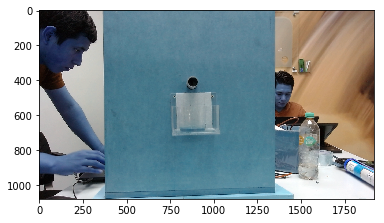

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
image  = video_rec[-1][1]
plt.imshow(image, interpolation='nearest')

In [3]:
import datetime as dt
# 2020-01-29T21:07:24.263Z
aa = dt.datetime.now().strftime("%Y-%m-%dT%H:%M:00Z")
print(aa)
type(aa)
def post_data2powerBI(measure,pipe_name, time):
    curl_comand = "curl --include --request POST --header \"Content-Type: application/json\" --data-binary \"[{\\\"measure_leak\\\" :"+str(measure)+",\\\"pipe_name\\\" :\\\""+pipe_name+"\\\",\\\"time\\\" :\\\""+time+"\\\"}]\" \"https://api.powerbi.com/beta/a40c0d68-338e-44ef-ab17-812ee42d12c7/datasets/6d10e7a8-4676-4209-af1f-5db45f59ac85/rows?key=URpxCMSMsG6zUZZ73FYC5UHwYgDlozvNSUBf1mxBq%2FCFU8AaNbJCuZOyW291BGCXt7xTg7cLIZaJUskfm%2BCmTQ%3D%3D\""
    print(curl_comand)
    reto = os.system(curl_comand)
    print(reto)

#post_data2powerBI(666,"pipe1", aa)

2020-01-29T18:30:00Z


In [3]:
import cv2
import numpy as np 
import time

global video_rec
#cap = cv2.VideoCapture(os.path.join("img_orig","offi_lima.MP4"))
cap = cv2.VideoCapture(1)
#cap.set(3, 1280)
#cap.set(4, 720)

cap.set(3, 1920)
cap.set(4, 1080)
while True:
    #time.sleep(1/50)
    #if len(video_rec) > 2 : video_rec.pop(0)
    #T = round(time.time(),3)
    _, im_np = cap.read()
    if not _:
        print("Video source doesn't respond")
        #video_rec.append([])
        break
    img, img_crop = pre_mask(im_np, crop = (.3 , .5, .43,.52),size=(256,256))
    cv2.imshow("test",img_crop)
    #cv2.imshow("orig",im_np)
    print(im_np.shape)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("s"):
        cv2.destroyAllWindows()
        break
    #video_rec.append([T, im_np])
cap.release()
cv2.destroyAllWindows()

(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1

In [7]:
type(1)==int

True